<a href="https://colab.research.google.com/github/lsiecker/Deep-Learning/blob/main/assignment_2/Assignment_2_2AMM10_22_23_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Details

## Group Name: group21

### Student 1: N.P.G.T. van Beuningen	1353624

### Student 2: D.P.M. van der Hoorn	1873334

### Student 3: L.R. Siecker	1344838

# Loading Data and Preliminaries

In [29]:
from google.colab import drive
import io
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import random
import requests
import pickle
import scipy.stats
import sklearn.metrics as sm
import time
from tqdm.notebook import tqdm, trange

import torch
from torch import nn, optim
from torch.autograd import Variable
from torch.cuda.memory import list_gpu_processes
from torch.nn.utils.rnn import pad_sequence
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, TensorDataset

In [2]:
base_url = "https://github.com/lsiecker/Deep-Learning/raw/main/assignment_2/data/"

In [3]:
def load_data(url, task):
    """
    Loads a numpy array from surfdrive.

    Input:
    url: Download link of dataset

    Outputs:
    dataset: numpy array with input features or labels
    """

    response = requests.get(url)
    response.raise_for_status()

    array = load_array(io.BytesIO(response.content), task)

    return array

In [4]:
def load_array(filename, task):
    datapoint = np.load(filename)
    if task == 'task 1':
        initial_state = datapoint['initial_state']
        terminal_state = datapoint['terminal_state']
        return initial_state, terminal_state
    elif task == 'task 2' or task == 'task 3':
        whole_trajectory = datapoint['trajectory']
        # change shape: (num_bodies, attributes, time) ->  num_bodies, time, attributes
        whole_trajectory = np.swapaxes(whole_trajectory, 1, 2)
        initial_state = whole_trajectory[:, 0]
        target = whole_trajectory[:, 1:, 1:]  # drop the first timepoint (second dim) and mass (last dim) for the prediction task
        return initial_state, target
    else:
        raise NotImplementedError("'task' argument should be 'task 1', 'task 2' or 'task 3'!")


In [5]:
"""
This cell gives an example of loading a datapoint with numpy for task 1.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
terminal_state: shape (n_bodies, [x, y])

"""

example = load_data(f"{base_url}task%201/train/trajectory_0.npz?raw=true", task='task 1')

initial_state, terminal_state = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {terminal_state.shape}')

body_idx = 2
print(f'The initial x-coordinate of the body with index {body_idx} in this trajectory was {initial_state[body_idx, 1]}')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 2)
The initial x-coordinate of the body with index 2 in this trajectory was -5.159721083543527


In [6]:
"""
This cell gives an example of loading a datapoint with numpy for task 2 / 3.

The arrays returned by the function are structures as follows:
initial_state: shape (n_bodies, [mass, x, y, v_x, v_y])
remaining_trajectory: shape (n_bodies, time, [x, y, v_x, v_y])

Note that for this task, you are asked to evaluate performance only with regard to the predictions of the positions (x and y).
If you use the velocity of the remaining trajectory for training,
this use should be purely auxiliary for the goal of predicting the positions [x,y] over time.
While testing performance of your model on the test set, you do not have access to v_x and v_y of the remaining trajectory.

"""

example = load_data(f'{base_url}task%202_3/train/trajectory_0.npz', task='task 2')

initial_state, remaining_trajectory = example
print(f'shape of initial state (model input): {initial_state.shape}')
print(f'shape of terminal state (to be predicted by model): {remaining_trajectory.shape}')

body_idx = 2
time_idx = 30
print(f'The y-coordinate of the body with index {body_idx} at time with index {time_idx} in remaining_trajectory was {remaining_trajectory[body_idx, time_idx, 1]}')

test_example = load_data(f'{base_url}task 2_3/test/trajectory_900.npz', task='task 3')
test_initial_state, test_remaining_trajectory = test_example
print(f'the shape of the input of a test data example is {test_initial_state.shape}')
print(f'the shape of the target of a test data example is {test_remaining_trajectory.shape}')
print(f'values of the test data example at time {time_idx}:\n {test_remaining_trajectory[:, time_idx]}')
print('note: velocity values are unobserved (NaNs) in the test data!')

shape of initial state (model input): (8, 5)
shape of terminal state (to be predicted by model): (8, 49, 4)
The y-coordinate of the body with index 2 at time with index 30 in remaining_trajectory was -0.3861544940435097
the shape of the input of a test data example is (8, 5)
the shape of the target of a test data example is (8, 49, 4)
values of the test data example at time 30:
 [[-5.85725792 -5.394571           nan         nan]
 [-6.03781257 -5.72445953         nan         nan]
 [-0.90623054 -6.93416278         nan         nan]
 [ 2.83149339 -7.50100819         nan         nan]
 [-2.85586881  1.77667501         nan         nan]
 [ 4.04424526  4.00563603         nan         nan]
 [-5.24887713 -4.83081005         nan         nan]
 [-5.81391023 -5.1109838          nan         nan]]
note: velocity values are unobserved (NaNs) in the test data!


# Helper Functions Setup

In [7]:
drive.mount('/content/drive')
destination_file = '/content/drive/MyDrive/'

def save_dataset(dataset, filename):
  "Saves dataset into file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'wb') as file:
     pickle.dump(dataset, file)
  print(f"Dataset saved to {filename}.")

def load_dataset(filename):
  "Loades dataset from file on Google Drive"
  filename = destination_file + filename
  with open(filename, 'rb') as file:
      dataset = pickle.load(file)
  return dataset

Mounted at /content/drive


### Plotting Functions

In [8]:
class PlotTraining():
    def __init__(self):
      self.train_loss = []
      self.evaluation_loss = []
      self.test_loss = []

    def add_train(self, loss):
      self.train_loss.append(loss)

    def add_evaluation(self, loss):
      self.evaluation_loss.append(loss)

    def add_test(self, loss):
      self.test_loss.append(loss)

    def plot(self):
      fig, ax1 = plt.subplots()
      ax1.set_xlabel('epochs')
      ax1.tick_params(axis='x')
      ax2 = ax1.twinx()
      if self.train_loss is not [None] * len(self.train_loss) \
          or self.evaluation_loss is not [None] * len(self.evaluation_loss) \
          or self.test_loss is not [None] * len(self.test_loss):
        ax2.set_ylabel('loss')

      color = ["tab:blue", "tab:orange", "tab:purple", "tab:red", "tab:green", "tab:pink"]

      if self.train_loss:
        ax2.plot(list(range(len(self.train_loss))), self.train_loss, label = "Training Loss", color=color[1])
      if self.evaluation_loss:
        ax2.plot(list(range(len(self.evaluation_loss))), self.evaluation_loss, label = "Validation Loss", color=color[3])
      if self.test_loss:
        ax2.plot(list(range(len(self.test_loss))), self.test_loss, label = "Test Loss", color=color[5])

      fig.legend()
      fig.tight_layout()
      plt.locator_params(axis='x', integer=True, tight=True)
      plt.show()

In [9]:
# Assuming you have the train and test datasets loaded as numpy arrays
def plot_prediction(title, y_pred, y_test, object_index, uncertainty):
    if uncertainty:
        predicted = y_pred #
        predicted_x = predicted[object_index, :, 0, 1]
        predicted_y = predicted[object_index, :, 1, 1]

        # Extract the uncertainty values for x and y
        uncertainty_x = predicted[object_index, :, 0, 3]
        uncertainty_y = predicted[object_index, :, 1, 3]

    else:
        predicted = y_pred.reshape(y_pred.shape[0], 49, 2)
        predicted_x = predicted[object_index, :, 0]
        predicted_y = predicted[object_index, :, 1]
    y_test = y_test.view(y_test.shape[0], 49, 2)
    true_x = y_test[object_index, :, 0]
    true_y = y_test[object_index, :, 1]

    # Filter the values where both x and y are zero
    mask = np.logical_or(predicted_x != 0, predicted_y != 0)
    predicted_x = predicted_x[mask]
    predicted_y = predicted_y[mask]

    mask = np.logical_or(true_x != 0, true_y != 0)
    true_x = true_x[mask]
    true_y = true_y[mask]

    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the x and y trajectories for the train dataset
    axs[0].plot(predicted_x.flatten(), predicted_y.flatten(), label='Predicted')

    if uncertainty:
        axs[0].fill_between(
            predicted_x.flatten(),
            predicted_y.flatten() - uncertainty_y.flatten(),
            predicted_y.flatten() + uncertainty_y.flatten(),
            alpha=0.5,
            label='Uncertainty (y)'
        )
        axs[0].fill_betweenx(
            predicted_y.flatten(),
            predicted_x.flatten() - uncertainty_x.flatten(),
            predicted_x.flatten() + uncertainty_x.flatten(),
            alpha=0.5,
            label='Uncertainty (x)'
        )

    axs[0].set_xlabel('X-coordinate')
    axs[0].set_ylabel('Y-coordinate')
    axs[0].set_title(f'{title} (Predicted)')
    axs[0].legend()

    # Plot the x and y trajectories for the test dataset
    axs[1].plot(true_x.flatten(), true_y.flatten(), label='Validation')
    axs[1].set_xlabel('X-coordinate')
    axs[1].set_ylabel('Y-coordinate')
    axs[1].set_title(f'{title} (Validation)')
    axs[1].legend()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()

In [10]:
def get_baseline_models(data_x, mask, task23):
    data = data_x[:, ::4, :][mask]
    x = data[:, 1]  # Initial x-coordinates
    y = data[:, 2]  # Initial y-coordinates
    v_x = data[:, 3]  # Initial x-velocities
    v_y = data[:, 4]  # Initial y-velocities

    if task23:
        time_points = torch.arange(1, 50).unsqueeze(1)  # Generate time points from 1 to 49
        # Calculate x_end for each time point
        x_end = x + v_x * time_points
        y_end = y + v_y * time_points

        x_end = torch.transpose(x_end, 0, 1)
        y_end = torch.transpose(y_end, 0, 1)

        # Combine the final x and y coordinates into a tensor
        baseline_pred_indexed = data[:, [1,2]].repeat(1, 49)
        linear_pred = torch.stack((x_end, y_end), dim=1)
        linear_pred_indexed = linear_pred.reshape(linear_pred.shape[0], 98)
    else:
        # Calculate the final x and y coordinates using the formula
        x_end = x + v_x * 5
        y_end = y + v_y * 5

        # Combine the final x and y coordinates into a tensor
        baseline_pred_indexed = data[:, [1,2]]
        linear_pred_indexed = torch.stack((x_end, y_end), dim=1)
    return baseline_pred_indexed, linear_pred_indexed

def get_predictions_model(mode, dataset, task23, device):
    if mode == "train":
      sliced_dataset = dataset[:800]
    elif mode == "val":
      sliced_dataset = dataset[800:]
    else:
      sliced_dataset = dataset

    x = [torch.tensor(array[0]) for array in sliced_dataset]
    y = [torch.tensor(array[1]) for array in sliced_dataset]

    x_rotations = [sequence_rotation(sequence) for sequence in x]

    x_pad = pad_sequence(x_rotations, batch_first=True, padding_value=0)
    y_pad = pad_sequence(y, batch_first=True, padding_value=0)

    mask = torch.all(x_pad != 0, dim=-1)
    mask = mask[:, ::4]

    if task23:
      y_pred = model(x_pad.to(device))
      y_pred_indexed = y_pred[mask]
      y_pred_indexed = y_pred_indexed.view(y_pred_indexed.shape[0], 49, 4).narrow(dim=-1, start=0, length=2).reshape(y_pred_indexed.shape[0], 98).cpu().detach().numpy()
    else:
      y_pred = model(x_pad.to(device)).reshape((x_pad.shape[0] * 9), 2).cpu().detach().numpy()
      y_pred_indexed = y_pred[mask.reshape((x_pad.shape[0] * 9),)]

    return y_pred_indexed, x_pad, y_pad, mask

In [11]:
def uncertainty_distribution(predictions):
    mean_predictions = np.mean(predictions, axis=0)

    # Calculate the variance across the runs
    variance = np.var(predictions, axis=0)

    # Calculate the standard deviation across the runs
    standard_deviation = np.std(predictions, axis=0)

    # Sample prediction from distribution
    uncertainty_distribution = np.random.normal(loc=mean_predictions, scale=np.sqrt(variance))

    # Calculate the 95% confidence intervals
    CI_lower = mean_predictions - 1.96 * standard_deviation
    CI_upper = mean_predictions + 1.96 * standard_deviation

    # Stack values so that all information regarding the distribution is available in output
    distribution_array = np.stack((uncertainty_distribution, mean_predictions, variance, standard_deviation, CI_lower, CI_upper), axis=-1)
    reshaped_dist_array = np.reshape(distribution_array, (predictions.shape[1], 49, 2, 6))

    return uncertainty_distribution, reshaped_dist_array

In [12]:
def sequence_rotation(source_sequence):
    x = source_sequence[:, 1]
    y = source_sequence[:, 2]
    v_x = source_sequence[:, 3]
    v_y = source_sequence[:, 4]

    # Create four rotated copies of the batch of sequences
    rotated_sequences = [
        torch.stack([source_sequence[:, 0], x, y, v_x, v_y], dim=1),  # 0 degrees rotation
        torch.stack([source_sequence[:, 0], y, -x, -v_y, v_x], dim=1),  # 90 degrees rotation
        torch.stack([source_sequence[:, 0], -x, -y, -v_x, -v_y], dim=1),  # 180 degrees rotation
        torch.stack([source_sequence[:, 0], -y, x, v_y, -v_x], dim=1),  # 270 degrees rotation
    ]

    rotated_sequences_tensor = torch.stack(rotated_sequences, dim=1)  # Shape: [batch_size, 4, sequence_length, 5]

    return rotated_sequences_tensor.view(rotated_sequences_tensor.shape[0] * rotated_sequences_tensor.shape[1], 5)

def collate_batch(batch):
    """
    Concatenate multiple datapoints to obtain a single batch of data
    """
    # arrays are stored as tuples; get respective lists
    source_points = [x[0] for x in batch]
    target_points = [x[1] for x in batch]

    source_sequences = [sequence_rotation(sequence) for sequence in source_points]

    # pad sequences in batch
    source_padded = pad_sequence(sequences = source_sequences,
                             batch_first = True)
    target_padded = pad_sequence(sequences = target_points,
                             batch_first = True)

    batch_mask = torch.all(source_padded != 0, dim=-1)
    return source_padded.to(device), target_padded.to(device), batch_mask[:, ::4]

In [13]:
def train(dataloader, log_interval, task23):

  model.train()

  start_time = time.time()
  for idx, (trajectory_points, target_points, batch_mask) in enumerate(tqdm(dataloader)):
        trajectory_points = trajectory_points.to(device)
        target_positions = target_points.to(device).narrow(dim=-1, start=0, length=2)

        model.optimizer.zero_grad()
        y_pred = model(trajectory_points)

        if task23:
          reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2)
          loss = model.criterion(reshaped_y_pred[batch_mask], target_positions[batch_mask])
        else:
          loss = model.criterion(y_pred[batch_mask], target_positions[batch_mask])

        loss.backward()
        model.optimizer.step()

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:3d} | {:5d}/{:5d} batches '
                  '| loss {:8.3f}'.format(epoch, idx, len(dataloader),
                                              loss))
            start_time = time.time()

  return loss

def evaluate(dataloader, task23):
    model.eval()

    with torch.no_grad():
        for idx, (trajectory_points, target_points, batch_mask) in enumerate(tqdm(dataloader)):

            trajectory_points = trajectory_points.to(device)
            target_points = target_points.to(device).narrow(dim=-1, start=0, length=2)

            y_pred = model(trajectory_points)
            if task23:
              reshaped_y_pred = y_pred.view(y_pred.shape[0], y_pred.shape[1], 49, 4).narrow(dim=-1, start=0, length=2)
              loss = model.criterion(reshaped_y_pred[batch_mask], target_points[batch_mask])
            else:
              loss = model.criterion(y_pred[batch_mask], target_points[batch_mask])

    return loss

# Model Setup

In [14]:
class Encoder(nn.Module):
    def __init__(self, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)


        self.double()


    def forward(self, src):
        """
        Forward pass of encoder model. It aims at
        transforming the input sentence to a dense vector
        """

        _, (hidden, cell) = self.rnn(src)

        return hidden, cell

In [15]:
class Decoder(nn.Module):
    def __init__(self, output_size, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)

        self.fc_out = nn.Linear(hid_dim, output_size)

        self.dropout = nn.Dropout(dropout)

        self.double()


    def forward(self, input, hidden, cell):
        """
        Forward pass of the decoder model. It aims at transforming
        the dense representation of the encoder into a sequence that is
        used for position prediction
        """

        output, _ = self.rnn(input, (hidden, cell))
        output_dropout = self.dropout(output)
        prediction = self.fc_out(output_dropout)

        # Only select points that were in original dataset
        reduced_output = prediction[:, ::4, :]

        return reduced_output

In [16]:
class TrainPointPredictor(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        self.criterion = nn.MSELoss()

        self.double()


    def forward(self, source_points):
        """
        Forward pass of the seq2seq model. It encodes the source sentence into
        a dense representation and thereafter transduces into the target
        sentence.

        Inputs:
        src: padded index representation of source sentences with shape [src len, batch size]
        trg:  padded index representation of target sentences with shape [trg len, batch size]

        Outputs:
        output:
        """

        #last hidden state of the encoder is used as the initial hidden state of the decoder
        hidden, cell = self.encoder(source_points)
        output = self.decoder(source_points, hidden, cell)

        return output

# Task **1**

## Data Handling and Preprocessing

In [17]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%201/train/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(train_data, "train_data")

In [18]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%201/test/trajectory_{i}.npz?raw=true", task='task 1'))
  save_dataset(test_data, "test_data")

In [19]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time:  3.33s | train loss    8.792 validation loss    9.539 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time:  0.96s | train loss    7.345 validation loss    8.181 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time:  0.83s | train loss    6.783 validation loss    7.761 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time:  0.83s | train loss    6.580 validation loss    7.622 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time:  0.95s | train loss    6.479 validation loss    7.556 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time:  0.98s | train loss    6.406 validation loss    7.505 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time:  0.96s | train loss    6.345 validation loss    7.453 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time:  0.97s | train loss    6.292 validation loss    7.394 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time:  0.96s | train loss    6.245 validation loss    7.328 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time:  0.82s | train loss    6.201 validation loss    7.258 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time:  0.81s | train loss    6.161 validation loss    7.187 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time:  0.82s | train loss    6.124 validation loss    7.116 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time:  0.83s | train loss    6.092 validation loss    7.047 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time:  0.81s | train loss    6.062 validation loss    6.980 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time:  0.82s | train loss    6.035 validation loss    6.918 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time:  0.82s | train loss    6.012 validation loss    6.860 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time:  0.83s | train loss    5.992 validation loss    6.807 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time:  0.83s | train loss    5.973 validation loss    6.758 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time:  0.83s | train loss    5.956 validation loss    6.715 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time:  0.81s | train loss    5.940 validation loss    6.676 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time:  0.83s | train loss    5.925 validation loss    6.640 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time:  1.03s | train loss    5.912 validation loss    6.608 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time:  0.96s | train loss    5.899 validation loss    6.576 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time:  0.99s | train loss    5.885 validation loss    6.547 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time:  1.00s | train loss    5.869 validation loss    6.521 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time:  0.93s | train loss    5.854 validation loss    6.497 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time:  0.84s | train loss    5.839 validation loss    6.476 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time:  0.83s | train loss    5.823 validation loss    6.456 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time:  0.82s | train loss    5.806 validation loss    6.438 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time:  0.83s | train loss    5.788 validation loss    6.422 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time:  0.83s | train loss    5.770 validation loss    6.407 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time:  0.84s | train loss    5.751 validation loss    6.392 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time:  0.84s | train loss    5.732 validation loss    6.379 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time:  0.84s | train loss    5.714 validation loss    6.366 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time:  0.83s | train loss    5.695 validation loss    6.354 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time:  0.84s | train loss    5.677 validation loss    6.342 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time:  0.85s | train loss    5.660 validation loss    6.331 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time:  1.01s | train loss    5.643 validation loss    6.319 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time:  1.04s | train loss    5.626 validation loss    6.308 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time:  1.07s | train loss    5.611 validation loss    6.296 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time:  1.04s | train loss    5.595 validation loss    6.284 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time:  0.97s | train loss    5.580 validation loss    6.273 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time:  0.85s | train loss    5.565 validation loss    6.262 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time:  0.84s | train loss    5.550 validation loss    6.251 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time:  0.86s | train loss    5.536 validation loss    6.240 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time:  0.85s | train loss    5.522 validation loss    6.229 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time:  0.88s | train loss    5.507 validation loss    6.219 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time:  0.88s | train loss    5.493 validation loss    6.209 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time:  0.85s | train loss    5.480 validation loss    6.200 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time:  0.87s | train loss    5.466 validation loss    6.191 
-----------------------------------------------------------


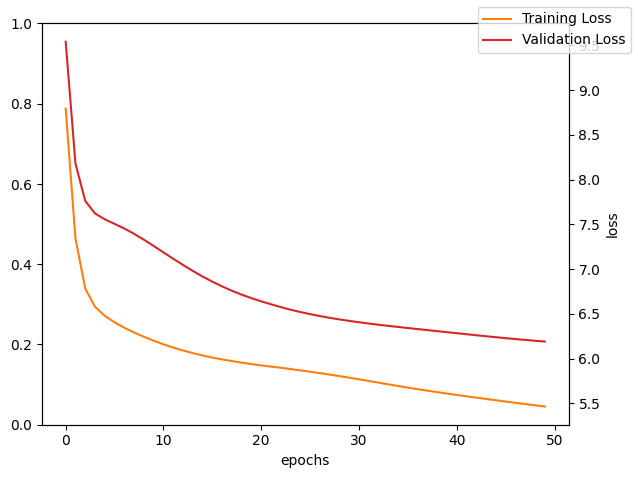

In [20]:
OUTPUT_SIZE = 2 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50          # Epochs for training BEST: 50
DROPOUT = 0.0        # Dropout factor in Decoder BEST: 0.0
N_LAYERS = 1         # Number of RNN layers  BEST: 1
HIDDEN_DIM = 128     # Dimension of the lstm's hidden state (Embedding)  BEST: 128
LEARNING_RATE = 1e-2 #  Learning rate BEST: 1e-2
WEIGHT_DECAY = 1e-5  # L2 Regularization in optimizer BEST: 1e-5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_losses, val_losses = [], []

plotter = PlotTraining()

# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = False).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = False).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [21]:
y_pred_train, train_x_pad, train_y_pad, train_mask = get_predictions_model(mode = "train", dataset = train_data, task23 = False, device = device)
y_train = train_y_pad.reshape((train_x_pad.shape[0] * 9), 2).cpu()
y_train_indexed = y_train[train_mask.reshape((train_x_pad.shape[0] * 9),)]

y_pred_val, val_x_pad, val_y_pad, val_mask = get_predictions_model(mode = "val", dataset = train_data, task23 = False, device = device)
y_val = val_y_pad.reshape((val_x_pad.shape[0] * 9), 2).cpu()
y_val_indexed = y_val[val_mask.reshape((val_x_pad.shape[0] * 9),)]

y_pred_test, test_x_pad, test_y_pad, test_mask = get_predictions_model(mode = "test", dataset = test_data, task23 = False, device = device)
y_test = test_y_pad.reshape((test_x_pad.shape[0] * 9), 2).cpu()
y_test_indexed = y_test[test_mask.reshape((test_x_pad.shape[0] * 9),)]


In [22]:
baseline_train_indexed, linear_train_indexed = get_baseline_models(data_x = train_x_pad, mask = train_mask, task23 = False)
baseline_val_indexed, linear_val_indexed = get_baseline_models(data_x = val_x_pad, mask = val_mask, task23 = False)
baseline_test_indexed, linear_test_indexed = get_baseline_models(data_x = test_x_pad, mask = test_mask, task23 = False)

In [23]:
print("R2 score baseline model on training data =", round(sm.r2_score(y_train_indexed, baseline_train_indexed), 2))
print("R2 score linear model on training data =", round(sm.r2_score(y_train_indexed, linear_train_indexed), 2))
print("R2 score RNN model on training data =", round(sm.r2_score(y_train_indexed, y_pred_train), 2))
print("------------")
print("R2 score baseline model on validation data =", round(sm.r2_score(y_val_indexed, baseline_val_indexed), 2))
print("R2 score linear model on validation data =", round(sm.r2_score(y_val_indexed, linear_val_indexed), 2))
print("R2 score RNN model on validation data =", round(sm.r2_score(y_val_indexed, y_pred_val), 2))
print("------------")
print("R2 score baseline model on testing data =", round(sm.r2_score(y_test_indexed, baseline_test_indexed), 2))
print("R2 score linear model on testing data =", round(sm.r2_score(y_test_indexed, linear_test_indexed), 2))
print("R2 score RNN model on testing data =", round(sm.r2_score(y_test_indexed, y_pred_test), 2))

R2 score baseline model on training data = 0.39
R2 score linear model on training data = 0.04
R2 score RNN model on training data = 0.74
------------
R2 score baseline model on validation data = 0.39
R2 score linear model on validation data = 0.0
R2 score RNN model on validation data = 0.71
------------
R2 score baseline model on testing data = 0.44
R2 score linear model on testing data = 0.02
R2 score RNN model on testing data = 0.78


In [40]:
overview = pd.DataFrame()
overview[["Test x", "Test y"]] = pd.DataFrame(y_test_indexed.numpy())
overview[["Predicted x", "Predicted y"]] = pd.DataFrame(y_pred_test)
overview

Test x    Test y  Predicted x  Predicted y
0    1.593872  2.682081    -2.113515     0.375494
1   -2.945501  4.100357    -0.671020     4.920419
2    0.208470 -7.571033    -0.137369    -3.561024
3    1.543807  2.508302    -3.360205     4.116451
4   -2.891316 -2.655327    -4.169366    -3.499360
..        ...       ...          ...          ...
643  0.511319  4.040832    -1.356371     6.567645
644 -6.376187  1.564882    -2.059347    -2.111973
645  1.185879 -8.417373     1.310554    -7.415399
646  0.418279  4.046557    -1.147710     2.531492
647 -6.653599  0.845832    -7.104998    -1.065870

[648 rows x 4 columns]

# Task **2**

## Data Handling and Preprocessing

In [ ]:
""" Get all training data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  train_data = load_dataset("train_data_task23")
except:
  train_data = []
  for i in trange(0,900):
    train_data.append(load_data(f"{base_url}task%202_3/train/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(train_data, "train_data_task23")

In [ ]:
""" Get all test data by trying to load a dataset file from Google Drive, if it fails then load from GitHub (slower) """
try:
  test_data = load_dataset("test_data_task23")
except:
  test_data = []
  for i in trange(900, 1000):
    test_data.append(load_data(f"{base_url}task%202_3/test/trajectory_{i}.npz?raw=true", task='task 2'))
  save_dataset(test_data, "test_data_task23")

In [ ]:
""" Create training, validation and test sets """
train_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[:800]]
val_dataset = [(torch.tensor(array[0]), torch.tensor(array[1])) for array in train_data[800:]]

train_dataloader = DataLoader(train_dataset, batch_size=5, collate_fn=collate_batch)
val_dataloader = DataLoader(val_dataset, batch_size=5, collate_fn=collate_batch)

## Model Training

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   1 | time: 23.54s | train loss    3.792 validation loss    5.899 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   2 | time: 21.44s | train loss    2.335 validation loss    3.996 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   3 | time: 22.83s | train loss    2.155 validation loss    3.585 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   4 | time: 21.74s | train loss    1.872 validation loss    3.345 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   5 | time: 22.50s | train loss    2.030 validation loss    3.280 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   6 | time: 22.15s | train loss    2.073 validation loss    3.197 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   7 | time: 22.17s | train loss    1.751 validation loss    3.155 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   8 | time: 22.19s | train loss    1.873 validation loss    3.137 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch   9 | time: 21.90s | train loss    2.059 validation loss    3.073 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  10 | time: 22.39s | train loss    1.980 validation loss    3.065 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  11 | time: 21.94s | train loss    1.961 validation loss    3.031 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  12 | time: 23.11s | train loss    1.948 validation loss    3.005 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  13 | time: 21.54s | train loss    1.798 validation loss    2.977 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  14 | time: 22.81s | train loss    1.958 validation loss    2.957 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  15 | time: 21.23s | train loss    1.905 validation loss    2.937 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  16 | time: 22.80s | train loss    1.892 validation loss    2.897 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  17 | time: 21.34s | train loss    1.863 validation loss    2.896 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  18 | time: 22.89s | train loss    1.888 validation loss    2.865 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  19 | time: 21.57s | train loss    1.551 validation loss    2.844 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  20 | time: 23.32s | train loss    1.876 validation loss    2.779 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  21 | time: 22.06s | train loss    1.887 validation loss    2.778 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  22 | time: 22.70s | train loss    1.750 validation loss    2.740 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  23 | time: 22.60s | train loss    1.716 validation loss    2.729 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  24 | time: 22.54s | train loss    1.707 validation loss    2.706 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  25 | time: 23.15s | train loss    1.713 validation loss    2.725 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  26 | time: 21.85s | train loss    1.902 validation loss    2.679 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  27 | time: 23.08s | train loss    1.824 validation loss    2.700 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  28 | time: 21.64s | train loss    1.861 validation loss    2.674 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  29 | time: 22.87s | train loss    1.940 validation loss    2.661 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  30 | time: 21.86s | train loss    1.763 validation loss    2.653 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  31 | time: 23.19s | train loss    1.565 validation loss    2.654 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  32 | time: 21.67s | train loss    1.839 validation loss    2.642 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  33 | time: 22.85s | train loss    1.683 validation loss    2.626 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  34 | time: 22.01s | train loss    1.651 validation loss    2.615 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  35 | time: 22.51s | train loss    1.840 validation loss    2.603 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  36 | time: 22.41s | train loss    1.773 validation loss    2.643 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  37 | time: 22.59s | train loss    1.564 validation loss    2.636 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  38 | time: 22.74s | train loss    1.867 validation loss    2.622 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  39 | time: 22.12s | train loss    1.701 validation loss    2.641 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  40 | time: 23.65s | train loss    1.616 validation loss    2.622 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  41 | time: 22.00s | train loss    1.676 validation loss    2.621 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  42 | time: 23.28s | train loss    1.794 validation loss    2.612 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  43 | time: 21.76s | train loss    1.925 validation loss    2.646 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  44 | time: 23.17s | train loss    1.745 validation loss    2.614 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  45 | time: 21.60s | train loss    1.927 validation loss    2.612 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  46 | time: 23.40s | train loss    1.913 validation loss    2.595 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  47 | time: 22.46s | train loss    1.826 validation loss    2.614 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  48 | time: 22.71s | train loss    1.753 validation loss    2.609 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  49 | time: 23.07s | train loss    1.887 validation loss    2.579 
-----------------------------------------------------------


  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

-----------------------------------------------------------
| end of epoch  50 | time: 22.15s | train loss    1.712 validation loss    2.585 
-----------------------------------------------------------


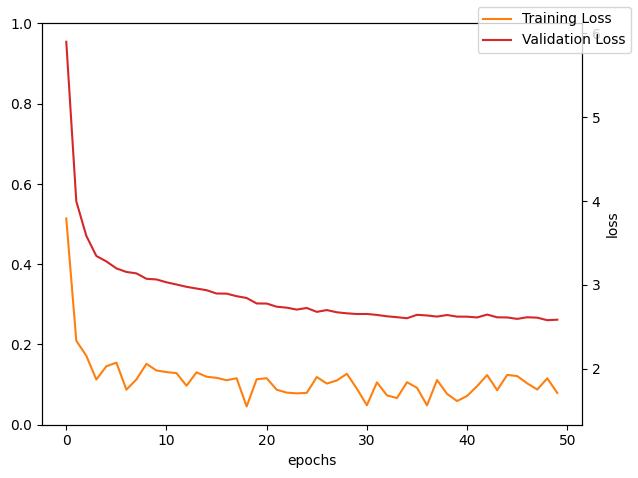

In [ ]:
OUTPUT_SIZE = 49*4 # Length of output sequence
EMB_DIM = 5 # Length of input sequence (input for RNN layer)

# HYPERPARAMETERS TO TUNE
EPOCHS = 50 #  BEST: 50, starts overfitting afterwards
DROPOUT = 0.5 #  BEST: 0.5
N_LAYERS = 1 # Number of RNN layers  BEST: 1
HIDDEN_DIM = 512 # Dimension of the lstm's hidden state (Embedding)  BEST: 256
LEARNING_RATE = 0.05 #  BEST: 0.1
WEIGHT_DECAY = 1e-2

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

enc = Encoder(emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)
dec = Decoder(output_size=OUTPUT_SIZE, emb_dim=EMB_DIM, hid_dim=HIDDEN_DIM, n_layers=N_LAYERS, dropout=DROPOUT)

model = TrainPointPredictor(enc, dec, device).to(device)
model.optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = lr_scheduler.LinearLR(model.optimizer, start_factor=1, end_factor=0.5, total_iters=EPOCHS)

train_loss, val_loss = [], []

plotter = PlotTraining()

# training loop
for epoch in range(1, EPOCHS + 1):
    epoch_start_time = time.time()

    train_loss = train(train_dataloader, 500, task23 = True).cpu().detach().numpy()
    val_loss = evaluate(val_dataloader, task23 = True).cpu().detach().numpy()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    plotter.add_train(train_loss)
    plotter.add_evaluation(val_loss)

    print('-' * 59)
    print('| end of epoch {:3d} | time: {:5.2f}s | '
          'train loss {:8.3f} '
          'validation loss {:8.3f} '.format(epoch,
                                           time.time() - epoch_start_time,
                                           train_losses[-1],
                                           val_losses[-1]))
    print('-' * 59)
    scheduler.step()
plotter.plot()

## Evaluation

In [ ]:
y_pred_train, train_x_pad, train_y_pad, train_mask = get_predictions_model(mode = "train", dataset = train_data, task23 = True, device = device)
y_train = train_y_pad.narrow(dim=-1, start=0, length=2).reshape((train_x_pad.shape[0] * 9), 98).cpu()
y_train_indexed = y_train[train_mask.reshape((train_x_pad.shape[0] * 9),)]

y_pred_val, val_x_pad, val_y_pad, val_mask = get_predictions_model(mode = "val", dataset = train_data, task23 = True, device = device)
y_val = val_y_pad.narrow(dim=-1, start=0, length=2).reshape((val_x_pad.shape[0] * 9), 98).cpu()
y_val_indexed = y_val[val_mask.reshape((val_x_pad.shape[0] * 9),)]

y_pred_test, test_x_pad, test_y_pad, test_mask = get_predictions_model(mode = "test", dataset = test_data, task23 = True, device = device)
y_test = test_y_pad.narrow(dim=-1, start=0, length=2).reshape((test_x_pad.shape[0] * 9), 98).cpu()
y_test_indexed = y_test[test_mask.reshape((test_x_pad.shape[0] * 9),)]

In [ ]:
baseline_train_indexed, linear_train_indexed = get_baseline_models(data_x = train_x_pad, mask = train_mask, task23 = True)
baseline_val_indexed, linear_val_indexed = get_baseline_models(data_x = val_x_pad, mask = val_mask, task23 = True)
baseline_test_indexed, linear_test_indexed = get_baseline_models(data_x = test_x_pad, mask = test_mask, task23 = True)

In [ ]:
print("R2 score baseline model on training data =", round(sm.r2_score(y_train_indexed, baseline_train_indexed), 2))
print("R2 score linear model on training data =", round(sm.r2_score(y_train_indexed, linear_train_indexed), 2))
print("R2 score RNN model on training data =", round(sm.r2_score(y_train_indexed, y_pred_train), 2))
print("------------")
print("R2 score baseline model on validation data =", round(sm.r2_score(y_val_indexed, baseline_val_indexed), 2))
print("R2 score linear model on validation data =", round(sm.r2_score(y_val_indexed, linear_val_indexed), 2))
print("R2 score RNN model on validation data =", round(sm.r2_score(y_val_indexed, y_pred_val), 2))
print("------------")
print("R2 score baseline model on testing data =", round(sm.r2_score(y_test_indexed, baseline_test_indexed), 2))
print("R2 score linear model on testing data =", round(sm.r2_score(y_test_indexed, linear_test_indexed), 2))
print("R2 score RNN model on testing data =", round(sm.r2_score(y_test_indexed, y_pred_test), 2))

R2 score baseline model on training data = 0.76
R2 score linear model on training data = -39.46
R2 score RNN model on training data = 0.87
------------
R2 score baseline model on validation data = 0.77
R2 score linear model on validation data = -39.91
R2 score RNN model on validation data = 0.88
------------
R2 score baseline model on testing data = 0.76
R2 score linear model on testing data = -42.5
R2 score RNN model on testing data = 0.87


<ipython-input-363-84eae371dbbb>:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_x = true_x[mask]
<ipython-input-363-84eae371dbbb>:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_y = true_y[mask]


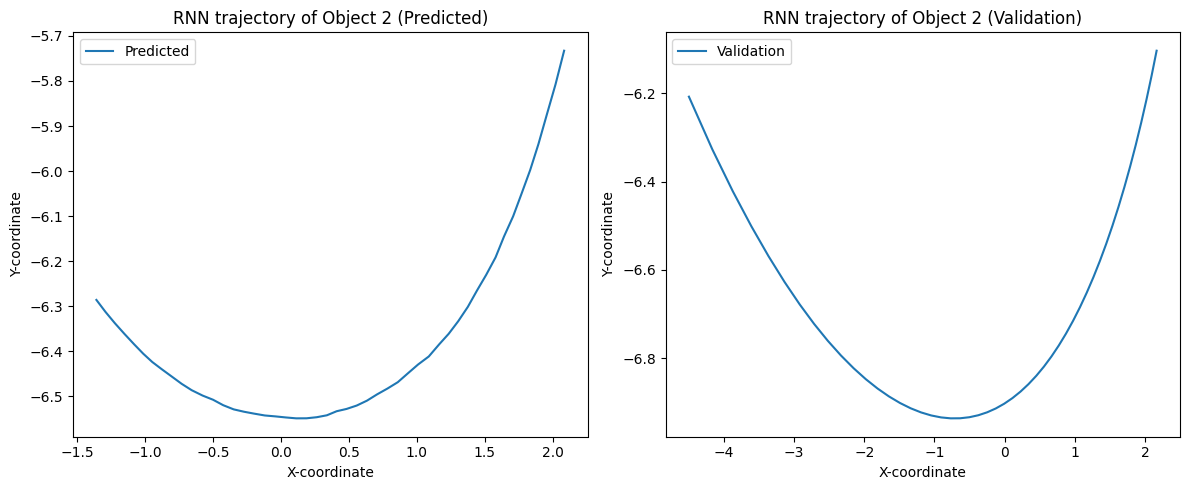

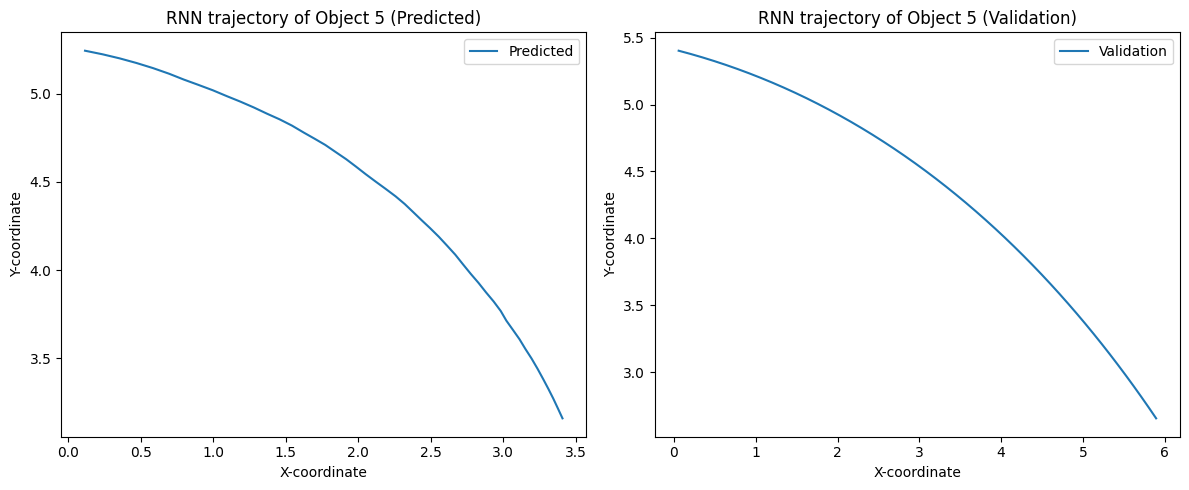

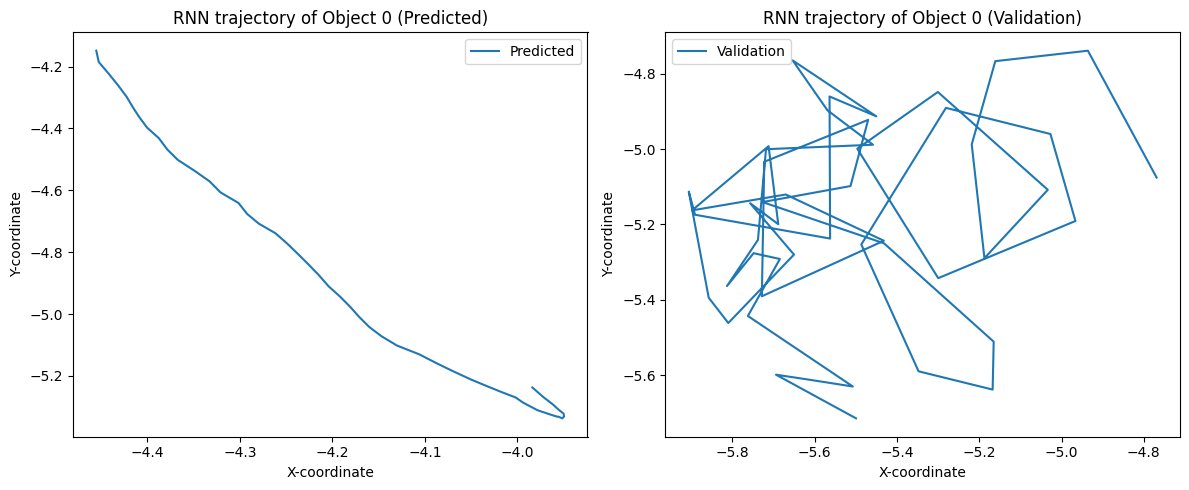

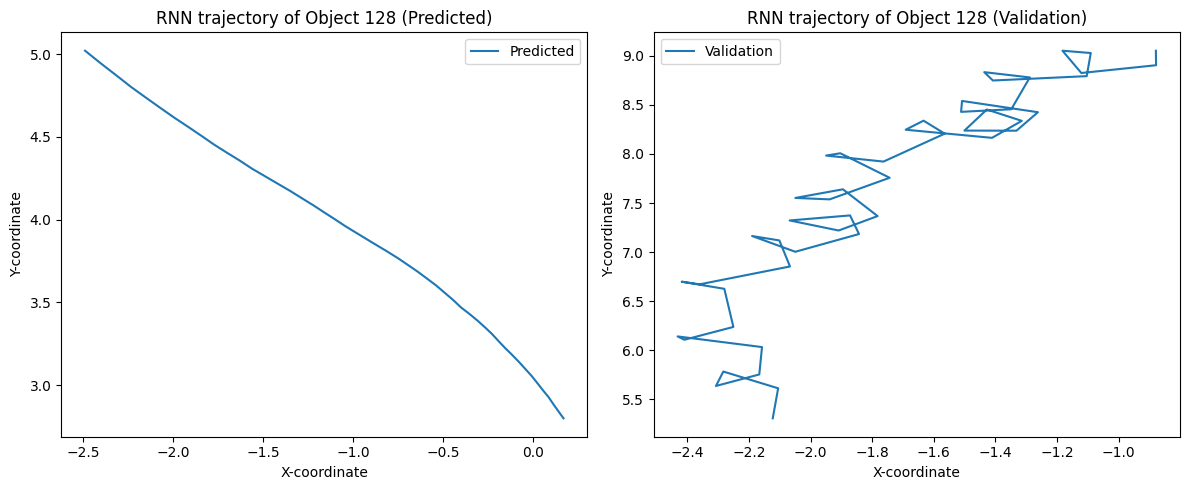

In [ ]:
# Evaluate the model on two good trajectories (2, 5) and two bad trajectories (0, 128)
objects = 2, 5, 0, 128

for object_idx in objects:
    plot_prediction(
      title = f'RNN trajectory of Object {object_idx}',
      y_pred = y_pred_test,
      y_test = y_test_indexed,
      object_index = object_idx,
      uncertainty = False)

<ipython-input-363-84eae371dbbb>:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  predicted_x = predicted_x[mask]
<ipython-input-363-84eae371dbbb>:23: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  predicted_y = predicted_y[mask]
<ipython-input-363-84eae371dbbb>:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_x = true_x[mask]
<ipython-input-363-84eae371dbbb>:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_y = true_y[mask]


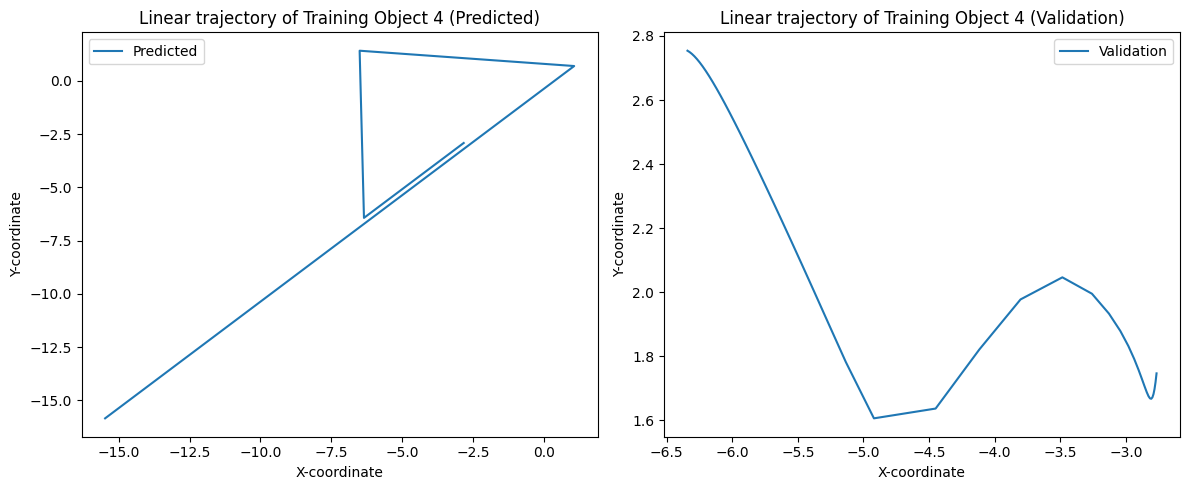

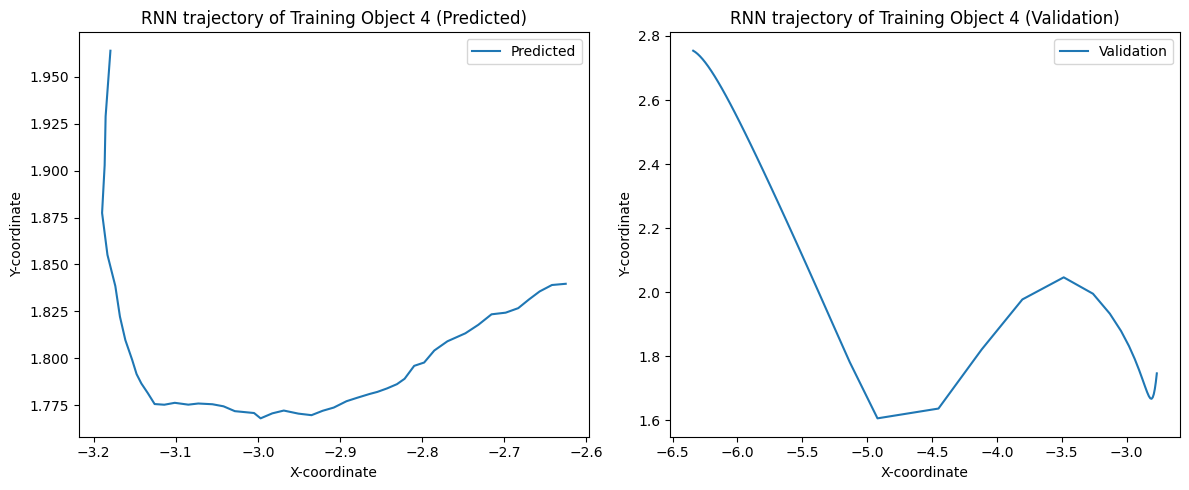

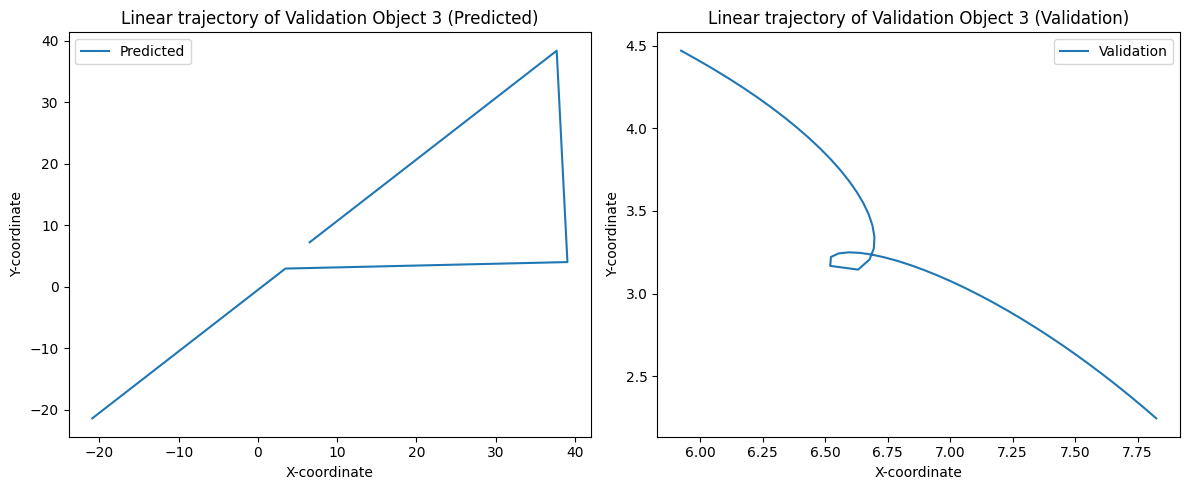

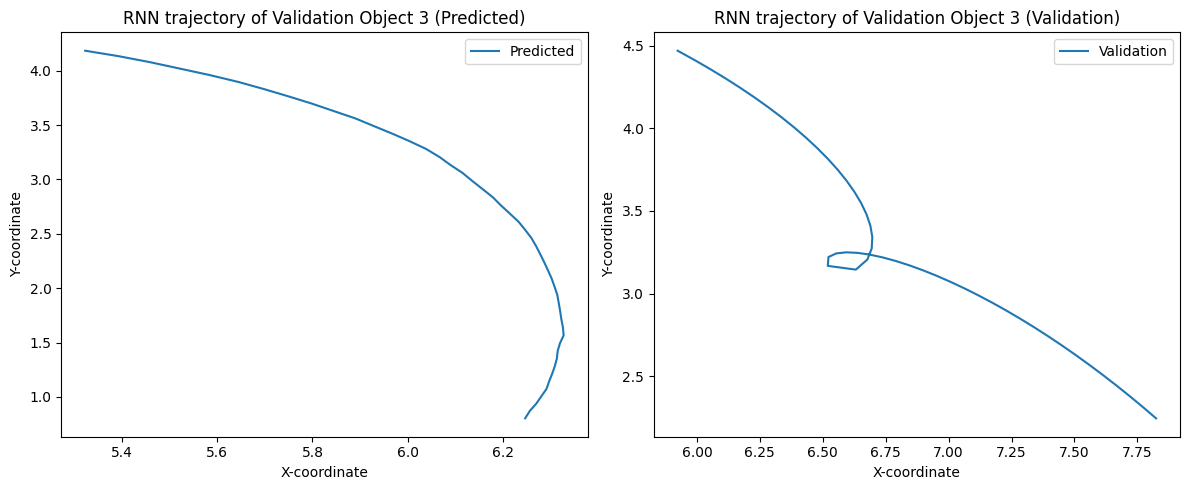

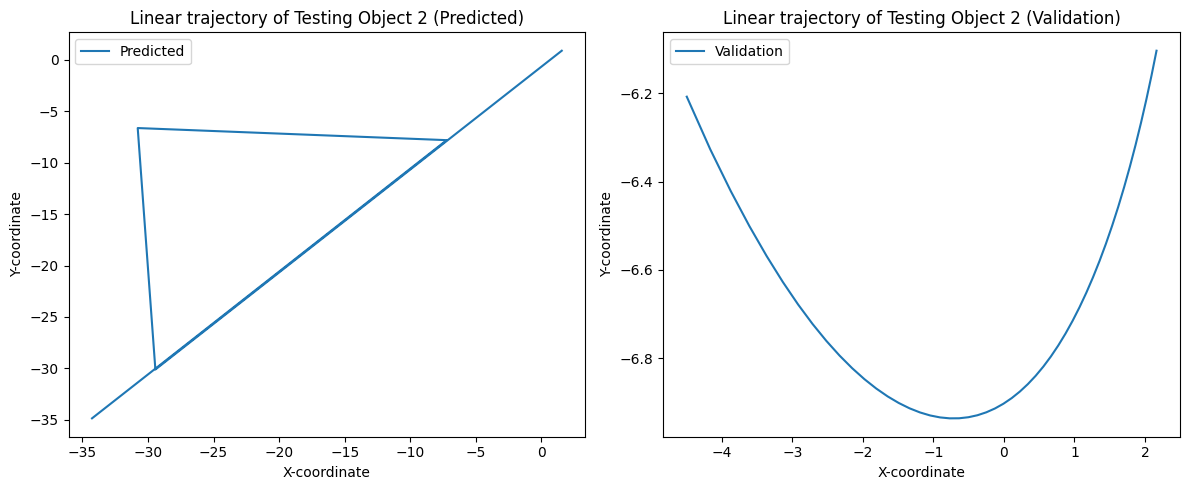

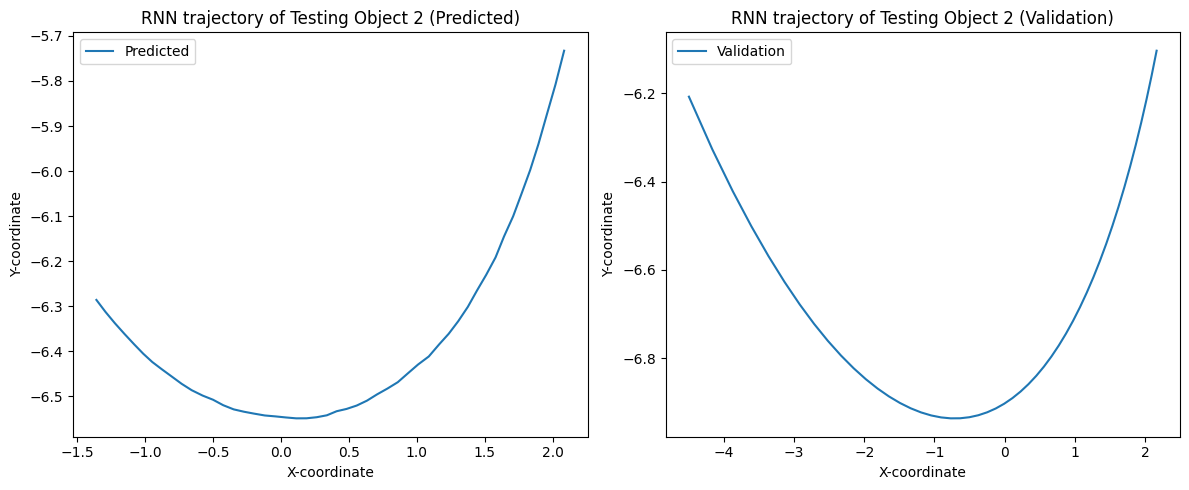

In [ ]:
# Show performance for linear model and trained rnn model on all datasets (train, val, test)
object_idx = 4
plot_prediction(
    title = f'Linear trajectory of Training Object {object_idx}',
    y_pred = linear_train_indexed,
    y_test = y_train_indexed,
    object_index = object_idx,
    uncertainty = False)
plot_prediction(
    title = f'RNN trajectory of Training Object {object_idx}',
    y_pred = y_pred_train,
    y_test = y_train_indexed,
    object_index = object_idx,
    uncertainty = False)

object_idx = 3
plot_prediction(
    title = f'Linear trajectory of Validation Object {object_idx}',
    y_pred = linear_val_indexed,
    y_test = y_val_indexed,
    object_index = object_idx,
    uncertainty = False)
plot_prediction(
    title = f'RNN trajectory of Validation Object {object_idx}',
    y_pred = y_pred_val,
    y_test = y_val_indexed,
    object_index = object_idx,
    uncertainty = False)

object_idx = 2
plot_prediction(
    title = f'Linear trajectory of Testing Object {object_idx}',
    y_pred = linear_test_indexed,
    y_test = y_test_indexed,
    object_index = object_idx,
    uncertainty = False)
plot_prediction(
    title = f'RNN trajectory of Testing Object {object_idx}',
    y_pred = y_pred_test,
    y_test = y_test_indexed,
    object_index = object_idx,
    uncertainty = False)

# Task **3**

## Data Handling and Preprocessing

In [ ]:
y_pred_train, train_x_pad, train_y_pad, train_mask = get_predictions_model(mode = "train", dataset = train_data, task23 = True, device = device)
y_train = train_y_pad.narrow(dim=-1, start=0, length=2).reshape((train_x_pad.shape[0] * 9), 98).cpu()
y_train_indexed = y_train[train_mask.reshape((train_x_pad.shape[0] * 9),)]

y_pred_val, val_x_pad, val_y_pad, val_mask = get_predictions_model(mode = "val", dataset = train_data, task23 = True, device = device)
y_val = val_y_pad.narrow(dim=-1, start=0, length=2).reshape((val_x_pad.shape[0] * 9), 98).cpu()
y_val_indexed = y_val[val_mask.reshape((val_x_pad.shape[0] * 9),)]

y_pred_test, test_x_pad, test_y_pad, test_mask = get_predictions_model(mode = "test", dataset = test_data, task23 = True, device = device)
y_test = test_y_pad.narrow(dim=-1, start=0, length=2).reshape((test_x_pad.shape[0] * 9), 98).cpu()
y_test_indexed = y_test[test_mask.reshape((test_x_pad.shape[0] * 9),)]

In [ ]:
for module in model.modules():
    if module.__class__.__name__.startswith('Dropout'):
        module.train()
fwd_passes = 20
def forward_predictions(model, x_pad, mask, fwd_passes):
    predictions = []

    for fwd_pass in tqdm(range(fwd_passes)):
        output = model(x_pad.to(device))
        reshaped_output = output.view(output.shape[0], output.shape[1], 49, 4).narrow(dim=-1, start=0, length=2).reshape((x_pad.shape[0] * 9), 98)

        np_output = reshaped_output.detach().cpu().numpy()

        predictions.append(np_output)

    predictions = np.array(predictions, dtype=np.float64)
    indexed_predictions = predictions[:, mask.reshape((x_pad.shape[0] * 9),)]
    return indexed_predictions

train_predictions = forward_predictions(model, train_x_pad, train_mask, fwd_passes)
val_predictions = forward_predictions(model, val_x_pad, val_mask, fwd_passes)
test_predictions = forward_predictions(model, test_x_pad, test_mask, fwd_passes)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
train_sampled, train_distribution = uncertainty_distribution(train_predictions)
val_sampled, val_distribution = uncertainty_distribution(val_predictions)
test_sampled, test_distribution = uncertainty_distribution(test_predictions)

In [ ]:
# Use sampled predictions to test results
print("R2 score baseline model on training data =", round(sm.r2_score(y_train_indexed, baseline_train_indexed), 2))
print("R2 score linear model on training data =", round(sm.r2_score(y_train_indexed, linear_train_indexed), 2))
print("R2 score RNN model on training data =", round(sm.r2_score(y_train_indexed, train_sampled), 2))
print("------------")
print("R2 score baseline model on validation data =", round(sm.r2_score(y_val_indexed, baseline_val_indexed), 2))
print("R2 score linear model on validation data =", round(sm.r2_score(y_val_indexed, linear_val_indexed), 2))
print("R2 score RNN model on validation data =", round(sm.r2_score(y_val_indexed, val_sampled), 2))
print("------------")
print("R2 score baseline model on testing data =", round(sm.r2_score(y_test_indexed, baseline_test_indexed), 2))
print("R2 score linear model on testing data =", round(sm.r2_score(y_test_indexed, linear_test_indexed), 2))
print("R2 score RNN model on testing data =", round(sm.r2_score(y_test_indexed, test_sampled), 2))

R2 score baseline model on training data = 0.76
R2 score linear model on training data = -39.46
R2 score RNN model on training data = 0.86
------------
R2 score baseline model on validation data = 0.77
R2 score linear model on validation data = -39.91
R2 score RNN model on validation data = 0.87
------------
R2 score baseline model on testing data = 0.76
R2 score linear model on testing data = -42.5
R2 score RNN model on testing data = 0.87


<ipython-input-363-84eae371dbbb>:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_x = true_x[mask]
<ipython-input-363-84eae371dbbb>:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_y = true_y[mask]


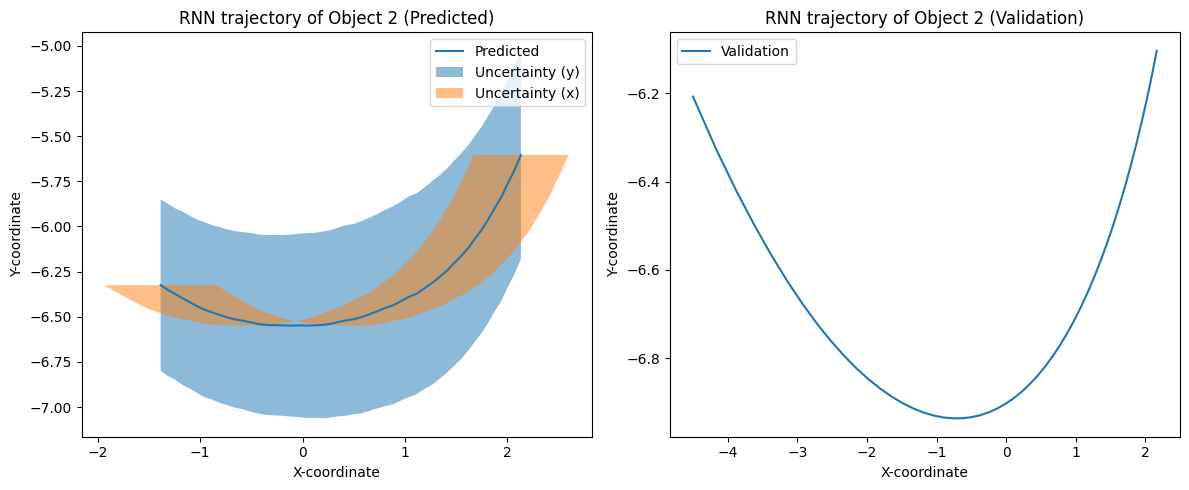

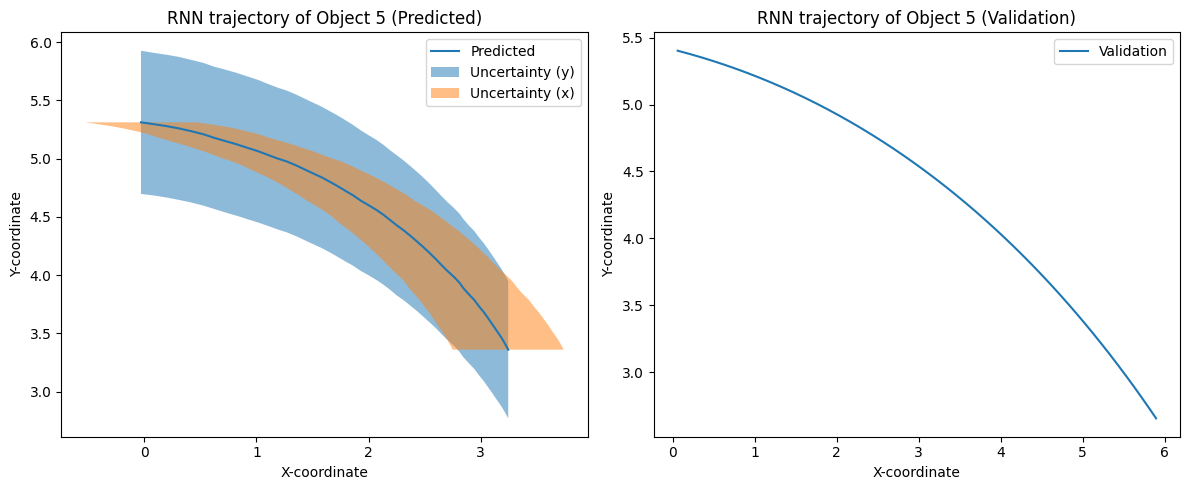

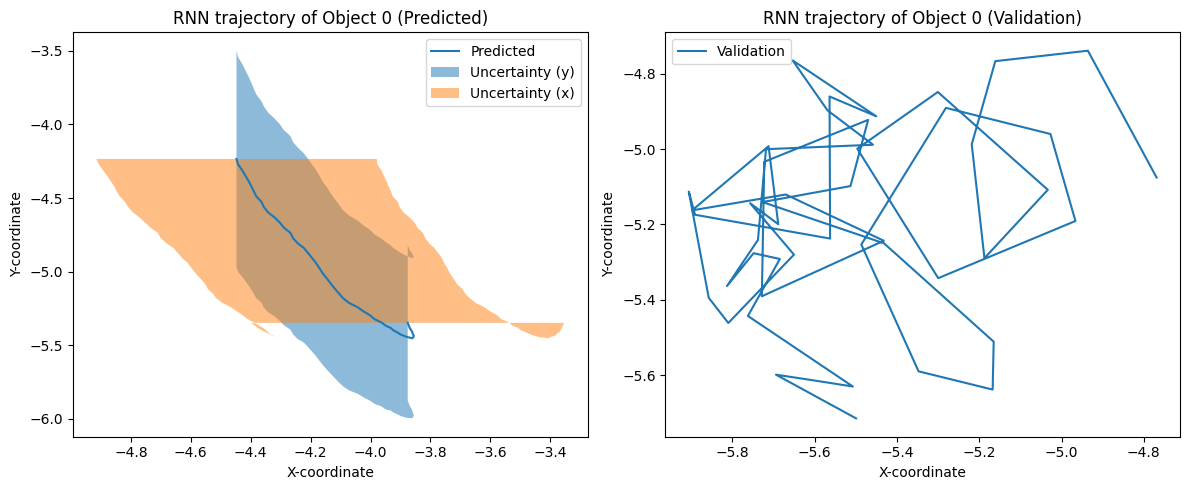

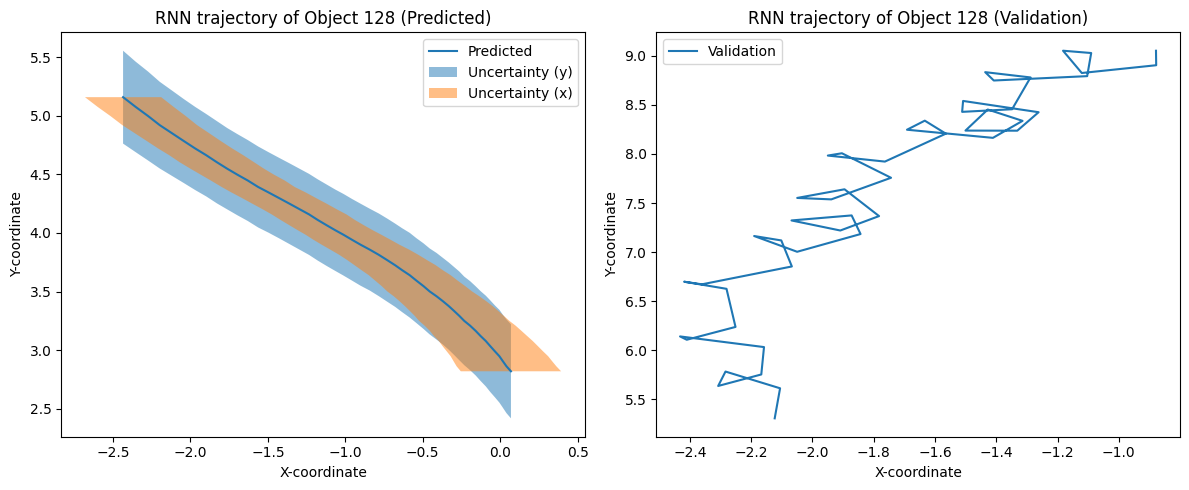

In [ ]:
# Evaluate the model on two good trajectories (8, 32) and two bad trajectories (0, 128)

for object_idx in objects:
    plot_prediction(
      title = f'RNN trajectory of Object {object_idx}',
      y_pred = test_distribution,
      y_test = y_test_indexed,
      object_index = object_idx,
      uncertainty = True)

<ipython-input-363-84eae371dbbb>:22: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  predicted_x = predicted_x[mask]
<ipython-input-363-84eae371dbbb>:23: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  predicted_y = predicted_y[mask]
<ipython-input-363-84eae371dbbb>:26: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_x = true_x[mask]
<ipython-input-363-84eae371dbbb>:27: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  true_y = true_y[mask]


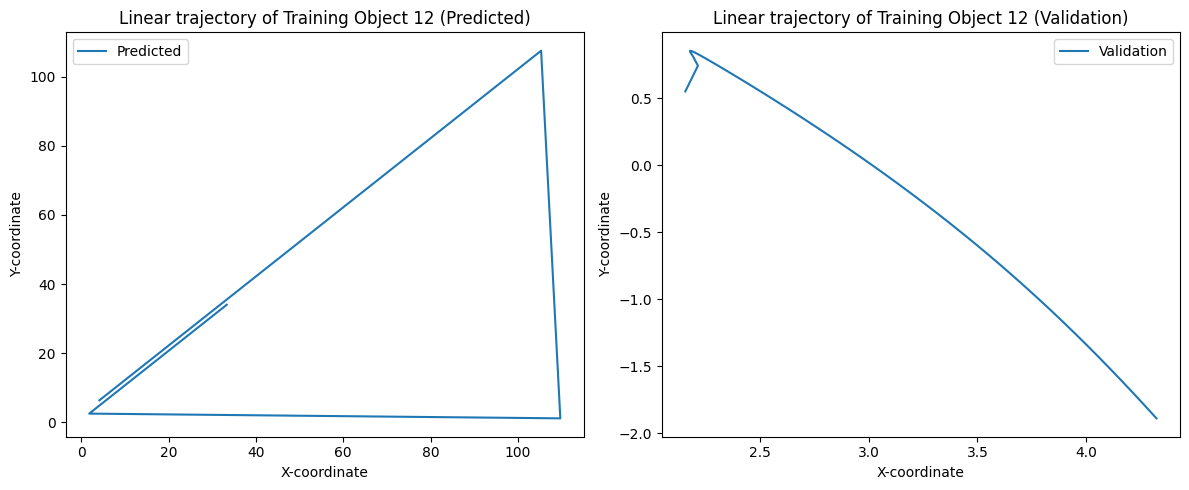

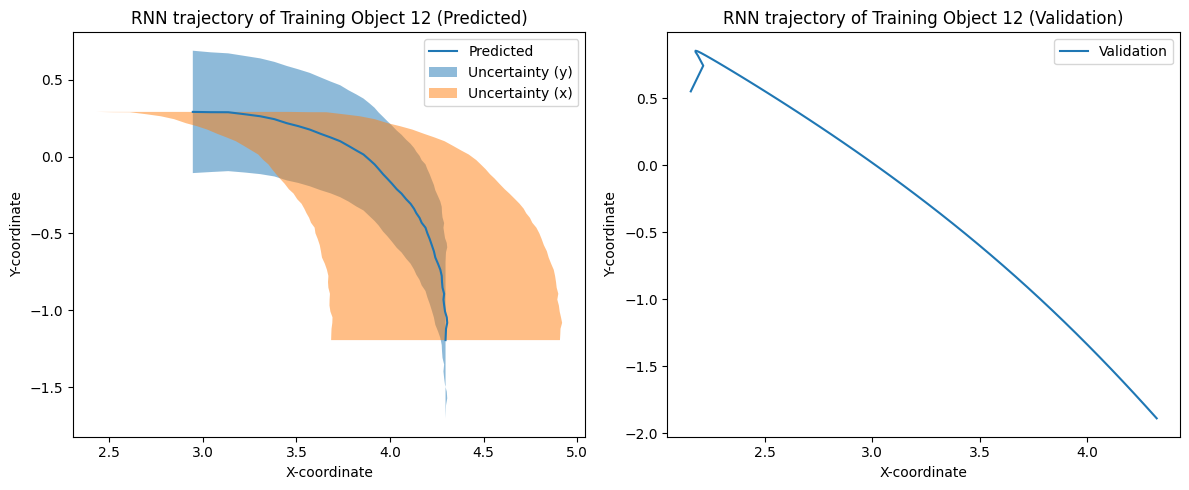

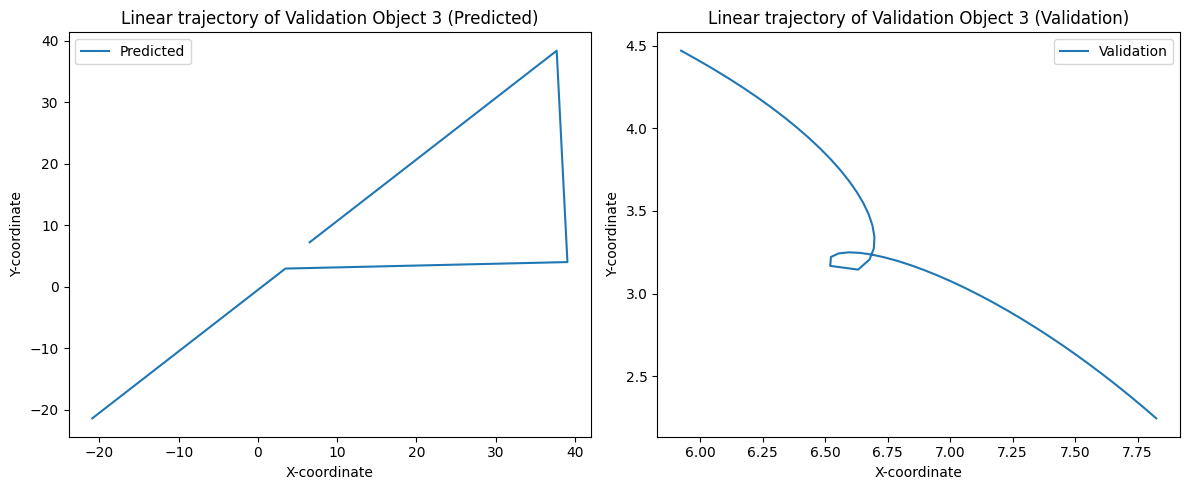

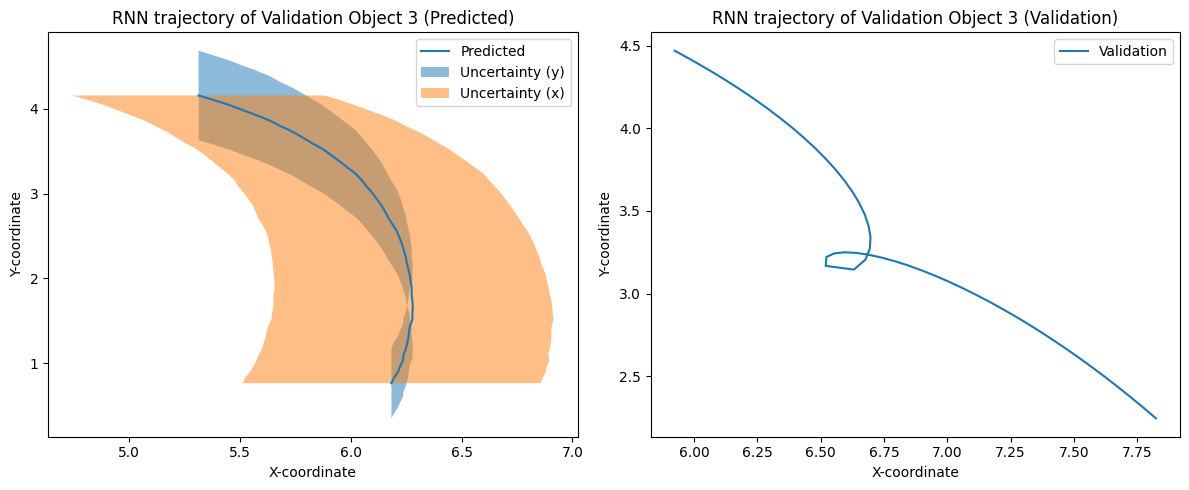

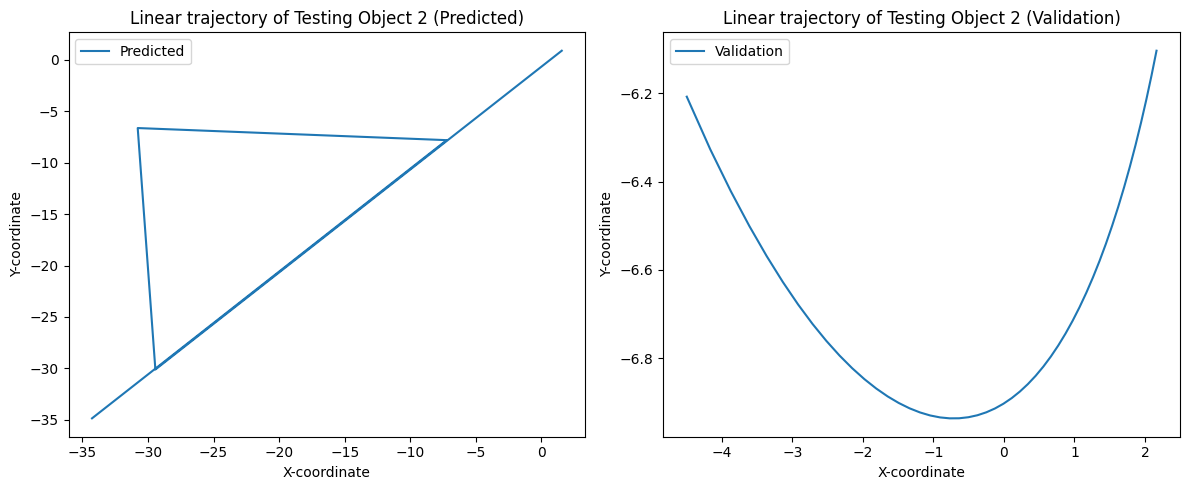

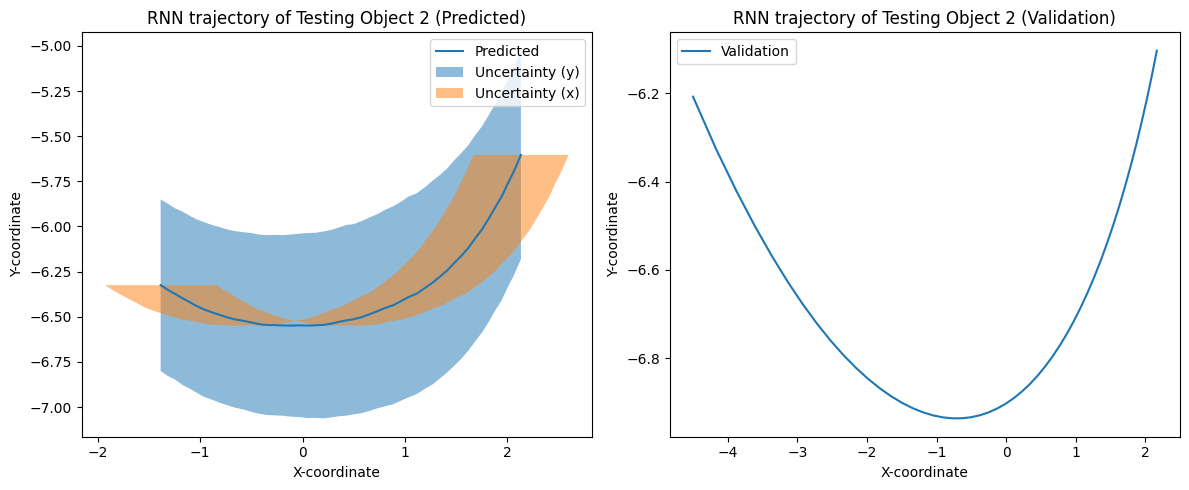

In [ ]:
# Show performance for linear model and trained rnn model on all datasets (train, val, test)
object_idx = 12
plot_prediction(
    title = f'Linear trajectory of Training Object {object_idx}',
    y_pred = linear_train_indexed,
    y_test = y_train_indexed,
    object_index = object_idx,
    uncertainty = False)
plot_prediction(
    title = f'RNN trajectory of Training Object {object_idx}',
    y_pred = train_distribution,
    y_test = y_train_indexed,
    object_index = object_idx,
    uncertainty = True)

object_idx = 3
plot_prediction(
    title = f'Linear trajectory of Validation Object {object_idx}',
    y_pred = linear_val_indexed,
    y_test = y_val_indexed,
    object_index = object_idx,
    uncertainty = False)
plot_prediction(
    title = f'RNN trajectory of Validation Object {object_idx}',
    y_pred = val_distribution,
    y_test = y_val_indexed,
    object_index = object_idx,
    uncertainty = True)

object_idx = 2
plot_prediction(
    title = f'Linear trajectory of Testing Object {object_idx}',
    y_pred = linear_test_indexed,
    y_test = y_test_indexed,
    object_index = object_idx,
    uncertainty = False)
plot_prediction(
    title = f'RNN trajectory of Testing Object {object_idx}',
    y_pred = test_distribution,
    y_test = y_test_indexed,
    object_index = object_idx,
    uncertainty = True)